# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Input, Dropout
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
import  shutil
import numpy as np 
import pandas as pd 
import os
import random



/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Data Loading and Preprocessing

In [2]:
! unzip -qq /kaggle/input/dogs-vs-cats/train.zip

In [3]:
! unzip -qq /kaggle/input/dogs-vs-cats/test1.zip

In [4]:
WORK_DIR = "/kaggle/working/"
TRAIN_SOURCE = os.path.join(WORK_DIR,"train")
TEST_SOURCE = os.path.join(WORK_DIR,"test1")

Create Training and Validation directories to be used for ImageDataGenerator

In [5]:
! mkdir /kaggle/working/training_data
! mkdir /kaggle/working/training_data/cats
! mkdir /kaggle/working/training_data/dogs
! mkdir /kaggle/working/validation_data
! mkdir /kaggle/working/validation_data/cats
! mkdir /kaggle/working/validation_data/dogs

In [6]:
TRAIN_DEST = "/kaggle/working/training_data/"
VALIDATION_DEST = "/kaggle/working/validation_data/"

Split the data into train and validation

In [7]:
SPLIT_SIZE = 0.9
training_count = int(len(os.listdir(TRAIN_SOURCE))*SPLIT_SIZE)
counter = 0
files = os.listdir(TRAIN_SOURCE)

#random.sample is used for shuffling the source file
for img in random.sample(files, len(files)):
    if counter < training_count:
        if img.startswith('cat'):
            src = os.path.join(TRAIN_SOURCE,img)
            dst = os.path.join(TRAIN_DEST,'cats',img)
            shutil.copyfile(src,dst)
            counter +=1 
        else:
            src = os.path.join(TRAIN_SOURCE,img)
            dst = os.path.join(TRAIN_DEST,'dogs',img)
            shutil.copyfile(src,dst)
            counter += 1

    else:
        if img.startswith('cat'):
            src = os.path.join(TRAIN_SOURCE,img)
            dst = os.path.join(VALIDATION_DEST,'cats',img)
            shutil.copyfile(src,dst)
        else:
            src = os.path.join(TRAIN_SOURCE,img)
            dst = os.path.join(VALIDATION_DEST,'dogs',img)
            shutil.copyfile(src,dst)


In [8]:
print(f"There are {len(os.listdir(os.path.join(TRAIN_DEST,'cats')))} images of cats for training")
print(f"There are {len(os.listdir(os.path.join(TRAIN_DEST,'dogs')))} images of dogs for training")
print(f"There are {len(os.listdir(os.path.join(VALIDATION_DEST,'cats')))} images of cats for validation")
print(f"There are {len(os.listdir(os.path.join(VALIDATION_DEST,'dogs')))} images of dogs for validation")

There are 11225 images of cats for training
There are 11275 images of dogs for training
There are 1275 images of cats for validation
There are 1225 images of dogs for validation


Create train and validation ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)

# Pass in the appropriate arguments to the flow_from_directory method
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DEST,
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

# Instantiate the ImageDataGenerator class 
validation_datagen = ImageDataGenerator(rescale=1./255)

# Pass in the appropriate arguments to the flow_from_directory method
validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DEST,
                                                            batch_size=32,
                                                            class_mode='binary',
                                                            target_size=(150, 150))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Model Creation 

In [10]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (150,150,3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(1,activation='sigmoid'),


])


model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

# Model Training

In [11]:
#create call back function to monitor validation loss
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:

# Train the model
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1,
                    validation_data=validation_generator,
                   callbacks=callback)

Epoch 1/30
704/704 [==============================] - 59s 67ms/step - loss: 0.5817 - accuracy: 0.6759 - val_loss: 0.4908 - val_accuracy: 0.7732
Epoch 2/30
704/704 [==============================] - 45s 64ms/step - loss: 0.4527 - accuracy: 0.7893 - val_loss: 0.4296 - val_accuracy: 0.7996
Epoch 3/30
704/704 [==============================] - 45s 63ms/step - loss: 0.3737 - accuracy: 0.8305 - val_loss: 0.3910 - val_accuracy: 0.8268
Epoch 4/30
545/704 [======================>.......] - ETA: 9s - loss: 0.2965 - accuracy: 0.8711

# Trying Dropout + Data Augmentation

In [36]:
image_gen = ImageDataGenerator(rescale=1.0 / 255,  # normalize pixel values
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                               validation_split=0.2
                              )
train_generator = image_gen.flow_from_directory(TRAIN_DEST,
                                                target_size=input_shape[:2],
                                                batch_size = 32,
                                                class_mode='binary',
                                                subset = 'training')

validation_generator = image_gen.flow_from_directory(TRAIN_DEST,
                                                target_size=input_shape[:2],
                                                batch_size = 32,
                                                class_mode='binary',
                                                subset = 'validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [23]:

model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

model.summary()

model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics=  'accuracy')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 63, 63, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                      

In [27]:
import keras
step_size_train = train_generator.samples//32
step_size_validate = validation_generator.samples//32

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
]

history = model.fit(train_generator,
         workers=4,
         steps_per_epoch= step_size_train,
         epochs = 30,
         validation_data=validation_generator,
         validation_steps=  step_size_validate,
         callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 142s 224ms/step - loss: 0.2610 - accuracy: 0.8896 - val_loss: 0.2911 - val_accuracy: 0.8774
Epoch 3/30
625/625 [==============================] - 141s 223ms/step - loss: 0.2585 - accuracy: 0.8885 - val_loss: 0.8023 - val_accuracy: 0.6723
Epoch 4/30
625/625 [==============================] - 140s 222ms/step - loss: 0.2511 - accuracy: 0.8938 - val_loss: 0.3352 - val_accuracy: 0.8540
Epoch 5/30
625/625 [==============================] - 140s 221ms/step - loss: 0.2514 - accuracy: 0.8925 - val_loss: 0.2751 - val_accuracy: 0.8832
Epoch 6/30
625/625 [==============================] - 141s 222ms/step - loss: 0.2482 - accuracy: 0.8961 - val_loss: 0.3439 - val_accuracy: 0.8508
Epoch 7/30
625/625 [==============================] - 124s 196ms/step - loss: 0.2423 - accuracy: 0.8974 - val_loss: 0.2419 - val_accuracy: 0.9000
Epoch 8/30
625/625 [==============================] - 139s 220ms/step - loss: 0.2451 - accuracy: 0.8984 - val_loss: 0.2720 -

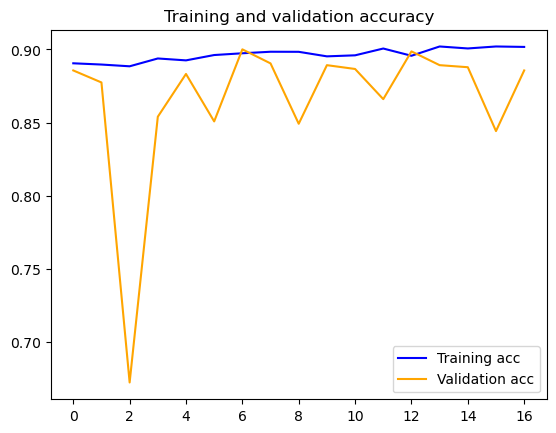

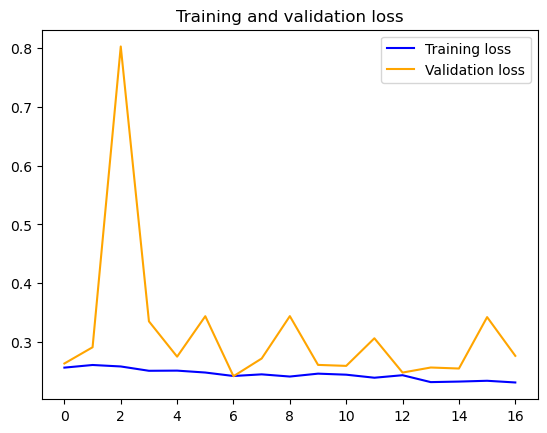

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot( acc, color = 'blue', label='Training acc')
plt.plot( val_acc, color = 'orange', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot( loss,color = 'blue', label='Training loss')
plt.plot( val_loss, color = 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()